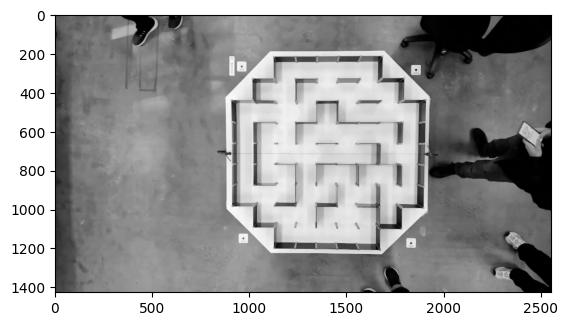

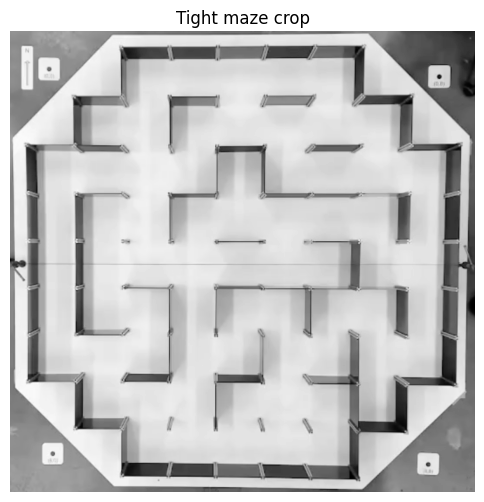

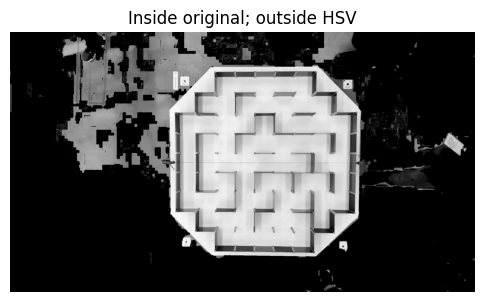

In [78]:
import cv2
import numpy as np
import random
import math
from matplotlib import pyplot as plt

random.seed(42)
#cv2.imwrite("maze_img0.png", img)
seed = 42
image_file = "raw2.png"
threshold_value = 150 # for the occupancy map
autocrop_threshold_value = 145 # for the autocrop adjustment/finetuning
unsafe_kernel_size = 7
unsafe_iterations = 3

# Edge detection parameters
canny_low_threshold = 50
canny_high_threshold = 150
sobel_threshold = 50

# Task 3 - BFS
bfs_n = 10  # Wall grid size (kept for reference)
bfs_start_node = 36  # Start node (0 to 80 for 9x9 grid)
bfs_end_node = 61   # End node (0 to 80 for 9x9 grid)

# Task 4 - PRM and Dijkstra
prm_total_nodes_count = 30
prm_connection_radius = 200
prm_start_node = 20            # Start node using same grid system as BFS (0 to 80 for 9x9 grid)
prm_end_node = 60              # End node using same grid system as BFS (0 to 80 for 9x9 grid)

# Task 5 - RRT
rrt_max_nodes_count = 500
rrt_step_size = 40
rrt_max_connection_length = 200
rrt_start_location = (50,50)
rrt_goal_location = (450,450)

# DO NOT ADD OTHER VARIABLES HERE
# Task 1.1 (1 mark): Display the occupancy map
image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

# Display resulting image
plt.imshow(image, cmap = 'gray')
plt.show()

def _contours(img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE):
    """Version-agnostic cv2.findContours: always returns the contours list."""
    found = cv2.findContours(img, mode, method)
    return found[0] if len(found) == 2 else found[1]

def _find_big_octagon_contour(img_bgr):
    """Edge/contour search for the big board; prefer ~octagon near image center."""
    H, W = img_bgr.shape[:2]
    g = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g, (5,5), 0)
    edge = cv2.Canny(g, 50, 150)
    edge = cv2.dilate(edge, cv2.getStructuringElement(cv2.MORPH_RECT, (5,5)), 2)

    # ✅ use the helper so it works on OpenCV 3 or 4
    cnts = _contours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None

    cx0, cy0 = W/2.0, H/2.0
    best, best_score = None, -1e18
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 0.05 * W * H:   # ignore small blobs
            continue

        x, y, w, h = cv2.boundingRect(c)
        ar_pen = abs(np.log(max(w,1) / float(max(h,1))))  # squareness penalty

        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        verts = len(approx)

        M = cv2.moments(c)
        if M["m00"] == 0:
            continue
        cx, cy = M["m10"]/M["m00"], M["m01"]/M["m00"]
        d2 = (cx - cx0)*2 + (cy - cy0)*2

        # prefer big, near center, ~8 sides, square-ish bbox
        score = 0.06*area - 0.001*d2 - 6.0*abs(verts - 8) - 8.0*ar_pen
        if score > best_score:
            best_score, best = score, approx

    if best is None:
        cmax = max(cnts, key=cv2.contourArea)
        best = cv2.approxPolyDP(cmax, 0.02 * cv2.arcLength(cmax, True), True)

    return best.reshape(-1, 2).astype(np.int32)

def _white_by_hsv(img_bgr, s_max=120, v_min=85):
    """White/near-white mask using ONLY HSV (low S, high V)."""
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    S, V = hsv[:,:,1], hsv[:,:,2]
    mask = np.where((S <= s_max) & (V >= v_min), 255, 0).astype(np.uint8)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, 2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  k, 1)
    return mask

def _shrink_until_white(poly_mask, white_mask, target_white=0.65, max_iter=40):
    """Iteratively erode polygon mask until enough HSV-white inside."""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    m = poly_mask.copy()
    best, best_ratio = m, 0.0
    for _ in range(max_iter):
        inside = (m==255)
        area = int(inside.sum())
        if area == 0: break
        ratio = float((white_mask[inside]==255).sum()) / area
        if ratio > best_ratio: best_ratio, best = ratio, m.copy()
        if ratio >= target_white: return m
        m = cv2.erode(m, kernel, 1)
    return best

def isMaze(img_bgr,
           hsv_low=(30,0,39), hsv_high=(130,255,255),
           white_s_max=120, white_v_min=85,
           white_target=0.65, max_shrink=40,
           erode_k=9, erode_iter=1, margin_px=8):
    """
    Returns: dict with keys
      'mask'            : final octagon mask (0/255)
      'crop_rect'       : (x1,y1,x2,y2)
      'cropped_gray'    : crop from ORIGINAL grayscale (inside unchanged)
      'composite_gray'  : full image: HSV filtering applied only OUTSIDE the octagon
    """
    H,W = img_bgr.shape[:2]
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # 1) initial octagon from edges/contours
    poly = _find_big_octagon_contour(img_bgr)
    if poly is None:
        # nothing found: return passthrough
        return {"mask": np.zeros((H,W), np.uint8), "crop_rect": (0,0,W,H),
                "cropped_gray": gray.copy(),
                "composite_gray": gray.copy()}

    poly_mask = np.zeros((H,W), np.uint8)
    cv2.fillPoly(poly_mask, [poly], 255)

    # 2) HSV-white mask and shrink polygon until white fraction is high
    white_mask = _white_by_hsv(img_bgr, s_max=white_s_max, v_min=white_v_min)
    final_mask = _shrink_until_white(poly_mask, white_mask,
                                     target_white=white_target, max_iter=max_shrink)

    # optional tiny tightening then small outward margin in crop
    if erode_iter > 0:
        final_mask = cv2.erode(final_mask,
                               cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(erode_k,erode_k)),
                               erode_iter)

    ys, xs = np.where(final_mask==255)
    if len(xs)==0:
        x1,y1,x2,y2 = 0,0,W,H
    else:
        x1 = max(0, xs.min()-margin_px);  y1 = max(0, ys.min()-margin_px)
        x2 = min(W, xs.max()+1+margin_px); y2 = min(H, ys.max()+1+margin_px)

    # 3) HSV filter for OUTSIDE only
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    outside_mask = cv2.inRange(hsv, np.array(hsv_low,np.uint8), np.array(hsv_high,np.uint8))
    outside_bgr  = cv2.bitwise_and(img_bgr, img_bgr, mask=outside_mask)

    composite = img_bgr.copy()
    outside = (final_mask==0)
    composite[outside] = outside_bgr[outside]

    return {
        "mask": final_mask,
        "crop_rect": (x1,y1,x2,y2),
        "cropped_gray": gray[y1:y2, x1:x2],
        "composite_gray": cv2.cvtColor(composite, cv2.COLOR_BGR2GRAY)
    }

# 0) Load
img_color = cv2.imread(image_file, cv2.IMREAD_COLOR)
assert img_color is not None

# 1) Your HSV range (outside processing)
H_low, H_high = 30, 130
S_low, S_high = 0, 255
V_low, V_high = 39, 255

out = isMaze(
    img_color,
    hsv_low=(H_low,S_low,V_low),
    hsv_high=(H_high,S_high,V_high),
    white_s_max=120,     # how permissive 'white' is (↑ for strong shadows)
    white_v_min=85,      # min brightness for 'white'
    white_target=0.65,   # raise if you want the polygon to hug the wall more
    max_shrink=40,
    erode_k=9, erode_iter=1, margin_px=8
)

x1,y1,x2,y2 = out["crop_rect"]
cropped      = out["cropped_gray"]
composite    = out["composite_gray"]   # full frame, HSV only outside octagon

# 2) Display
plt.figure(figsize=(6,6)); plt.imshow(cropped, cmap='gray'); plt.axis('off'); plt.title('Tight maze crop'); plt.show()
plt.figure(figsize=(6,6)); plt.imshow(composite, cmap='gray'); plt.axis('off'); plt.title('Inside original; outside HSV'); plt.show()

# keep using ⁠ image ⁠ if your downstream expects it
image = cropped

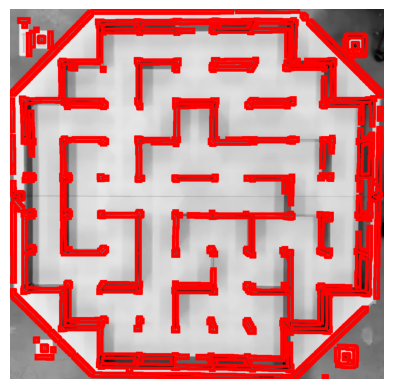

In [79]:
# --- Binarize, remove central horizontal seam, then build buffer zone & overlay ---

pixel_detection = 11
# If too much is being detected, increase this (more strict). If too little is being detected, decrease this (less strict)
detection_strictness = 20


# 1) Adaptive threshold (walls -> 255)
cropped_blur = cv2.medianBlur(cropped, 3)
binary_obstacles = cv2.adaptiveThreshold(
    cropped_blur, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
    pixel_detection, detection_strictness
)


h, w = binary_obstacles.shape[:2]

# 2) Detect long horizontal lines near the vertical center and erase them
seam_mask = np.zeros_like(binary_obstacles)

# Hough on edges within a central band
band_top = int(0.35 * h)
band_bot = int(0.65 * h)
edges = cv2.Canny(cropped_blur, 30, 90)
edges_mid = np.zeros_like(edges)
edges_mid[band_top:band_bot, :] = edges[band_top:band_bot, :]

lines = cv2.HoughLinesP(
    edges_mid, rho=1, theta=np.pi/180, threshold=50,
    minLineLength=int(0.50 * w), maxLineGap=25
)

if lines is not None:
    thick = max(5, int(0.01 * min(h, w)))
    for x1, y1, x2, y2 in lines[:, 0]:
        ang = abs(np.degrees(np.arctan2(y2 - y1, x2 - x1)))
        if (ang < 12) or (ang > 168):  # near-horizontal
            cv2.line(seam_mask, (x1, y1), (x2, y2), 255, thickness=thick)

# Morphological fallback: long+thin components in the same central band
if not np.any(seam_mask):
    mid_band = np.zeros_like(binary_obstacles)
    mid_band[band_top:band_bot, :] = binary_obstacles[band_top:band_bot, :]
    klen = max(31, w // 4)  # long horizontal kernel
    hker = cv2.getStructuringElement(cv2.MORPH_RECT, (klen, 3))
    mid_closed = cv2.morphologyEx(mid_band, cv2.MORPH_CLOSE, hker, iterations=1)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(mid_closed, connectivity=8)
    thin_px = max(5, int(0.02 * h))
    min_len = int(0.60 * w)
    for i in range(1, num):
        x, y, ww, hh, area = stats[i]
        if (ww >= min_len) and (hh <= thin_px) and (band_top <= y <= band_bot):
            comp = (labels == i).astype(np.uint8) * 255
            comp = cv2.dilate(comp, np.ones((3, 3), np.uint8), iterations=1)
            seam_mask = cv2.bitwise_or(seam_mask, comp)

# Erase detected seam from the binary mask (walls are 255)
binary_obstacles[seam_mask > 0] = 0

# 3) Dilation + buffer zone
kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8)
expanded_obstacles = cv2.dilate(binary_obstacles, kernel, iterations=unsafe_iterations)
buffer_zone = cv2.subtract(expanded_obstacles, binary_obstacles)

# 4) Visualize (red buffer)
colour_image = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)
colour_image[buffer_zone == 255] = [255, 0, 0]
plt.imshow(colour_image); plt.axis('off'); plt.show()

# cropped_blur = cv2.medianBlur(cropped, 3)
# binary_obstacles = cv2.adaptiveThreshold(
#     cropped_blur, 255,
#     cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
#     51, 25
# )

# # _, binary_obstacles = cv2.threshold(cropped, threshold_value, 255, cv2.THRESH_BINARY_INV)

# # Keep the rest the same
# kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8)
# expanded_obstacles = cv2.dilate(binary_obstacles, kernel, iterations=unsafe_iterations)
# buffer_zone = cv2.subtract(expanded_obstacles, binary_obstacles)

# colour_image = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)
# colour_image[buffer_zone == 255] = [255, 0, 0]

# plt.imshow(colour_image); plt.show()

In [80]:
# Task 2.1 (0 marks):  Complete the graph class

class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        self.nodes[node_id] = Node(node_id, x, y)
        self.edges[node_id] = []

    def add_edge(self, node_id1, node_id2, weight):
        self.edges[node_id1].append((node_id2, weight))
        self.edges[node_id2].append((node_id1, weight))

    def remove_edge(self, node_id1, node_id2):
        for i in self.edges[node_id1]:
            if i[0] == node_id2:
                index1 = i;
        for i in self.edges[node_id2]:
            if i[0] == node_id1:
                index2 = i;
                
        self.edges[node_id1].remove(index1)
        self.edges[node_id2].remove(index2)
    
    def get_nodes(self):
        return self.nodes
    
    def get_edges(self):
        return self.edges
    
    def get_edge_weight(self, node_id1, node_id2):
        for i in self.edges[node_id1]:
            if i[0] == node_id2:
                return i[1]

In [81]:
# This is a useful function that you may choose to implement and use 
# It looks through the image to see if the path is clear between one coordinate to the next
# Returns True or False 
def path_clear(image, x1, y1, x2, y2):

    ROI = image[y1:y2, x1:x2]
    
    for i in ROI:
        for j in i:
            if (j == [255, 0, 0]).all() or (j == [0, 0, 0]).all():
                return False
    
    return True

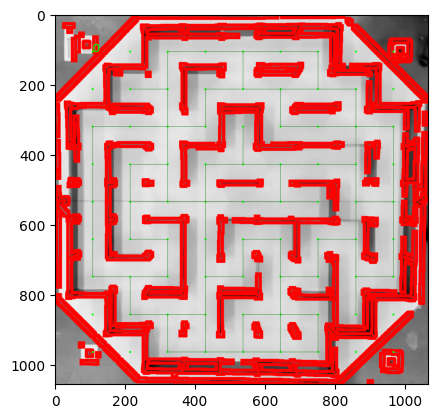

In [82]:
bfs_image = colour_image
bfs_graph = Graph()

side_length = 1180
gap = side_length/(bfs_n + 1)
width = 1
radius = 3
id = 0;

# Adding Nodes
for i in range(1, bfs_n + 1):
    y = i*gap
    for j in range(1, bfs_n + 1):
        x = j*gap
        bfs_graph.add_node(id, x, y)
        id+=1
        
nodes = bfs_graph.get_nodes()

# Adding Edges
for j in range(0, id):
    node = nodes[j]
    x = int(node.x)
    y = int(node.y)
    right = int(node.x + gap)
    down = int(node.y + gap)
    
    if (j % bfs_n) != (bfs_n - 1):
        if path_clear(bfs_image, x, y, right, y + 1):
            id2 = j + 1
            bfs_graph.add_edge(j, id2, 1)

    if j < id - bfs_n:
        if path_clear(bfs_image, x, y, x + 1, down):
            id2 = j + bfs_n
            bfs_graph.add_edge(j, id2, 1)
    
    # Draw Nodes
    cv2.circle(bfs_image,(int(x),int(y)), 3, (0,255,0), -1)

# Draw Edges
for j in range(0, id):
    node = nodes[j]
    x = int(node.x)
    y = int(node.y)
    right = int(node.x + gap)
    down = int(node.y + gap)
        
    for edge in bfs_graph.edges[node.id]:
        partner_id = edge[0]
        partner_node = bfs_graph.nodes[partner_id]
        
        cv2.line(bfs_image,(int(x), int(y)),(int(partner_node.x), int(partner_node.y)),(0, 125, 0), 1)


font = cv2.FONT_HERSHEY_SIMPLEX

first_node = bfs_graph.nodes[0]
cv2.putText(bfs_image,str(first_node.id),(int(first_node.x),int(first_node.y)),font,1,(0,255,0),2,cv2.LINE_AA)

last_node = bfs_graph.nodes[id - 1]
cv2.putText(bfs_image,str(last_node.id),(int(last_node.x),int(last_node.y)),font,1,(0,255,0),2,cv2.LINE_AA)

# Display Resulting Image
plt.imshow(bfs_image)
plt.show()

In [83]:
# Task 3.2 (5 marks): Implement BFS

# Returns an array of nodes in order of which nodes are visited next.
# ie. [0, 10, 20, 30, 40, 50, 60, 70, 71, 72, 73, 74, 75, 76, 77, 78, 88, 98, 99]

def bfs(graph, start_node_id, end_node_id):
    
    visited = []
    Q = [start_node_id]
    parent = {}
    path = []
    
    while Q:

        current = Q.pop(0)
        visited.append(current)
        
        # Find all the connected nodes and add to Q
        for partner in graph.edges[current]:
            partner_id = partner[0]
            
            if partner_id not in visited and partner_id not in Q:
                # Make the current the parent to the partners
                parent[partner_id] = current
                Q.append(partner_id)
    
    current = end_node_id
    
    # Create the path by going backwards to the parent
    while True:
        path.append(current)
        if current == start_node_id:
            break
        current = parent[current]
    
    # Reverse to go in forwards direction
    path.reverse()
    return path

Path: [36, 35, 34, 33, 43, 42, 41, 51, 52, 62, 61]


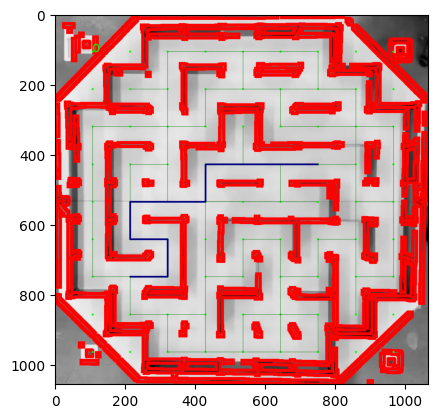

In [84]:
# Task 3.2: Implement BFS continued

# Run BFS and display the output
path = bfs(bfs_graph,bfs_start_node,bfs_end_node)

for i in range(len(path)):
    
    current_x = int(bfs_graph.nodes[path[i]].x)
    current_y = int(bfs_graph.nodes[path[i]].y)
    if i + 1 < len(path):
        next_x = int(bfs_graph.nodes[path[i + 1]].x)
        next_y = int(bfs_graph.nodes[path[i + 1]].y)
        cv2.line(bfs_image,(current_x, current_y),(next_x, next_y),(0, 0, 125), 3)

# Display the resulting image
print(f"Path: {path}")
plt.imshow(bfs_image)
plt.show()

🤖 ROBOT MOVEMENT COMMANDS
Path: [36, 35, 34, 33, 43, 42, 41, 51, 52, 62, 61]
Commands: FFFLFRFFLFLFRFRFL
Total moves: 10
Total turns: 7
Command breakdown: F F F L F R F F L F L F R F R F L
Final orientation: NORTH (Robot ends facing true north ⬆️)


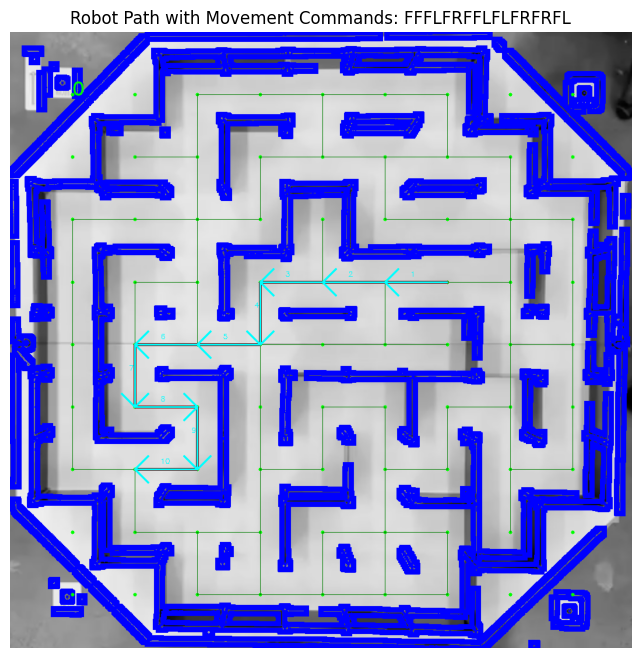


📋 STEP-BY-STEP ROBOT MOVEMENTS:
--------------------------------------------------
Step | Node | Command | Description
--------------------------------------------------
  0  |  36  |    -    | Starting position
  1  |  35  |    F    | Move forward to node 35
  2  |  34  |    F    | Move forward to node 34
  3  |  33  |    F    | Move forward to node 33
     |     |    L    | Turn left (90° counterclockwise)
  4  |  43  |    F    | Move forward to node 43
     |     |    R    | Turn right (90° clockwise)
  5  |  42  |    F    | Move forward to node 42
  6  |  41  |    F    | Move forward to node 41
     |     |    L    | Turn left (90° counterclockwise)
  7  |  51  |    F    | Move forward to node 51
     |     |    L    | Turn left (90° counterclockwise)
  8  |  52  |    F    | Move forward to node 52
     |     |    R    | Turn right (90° clockwise)
  9  |  62  |    F    | Move forward to node 62
     |     |    R    | Turn right (90° clockwise)
 10  |  61  |    F    | Move forward 

In [85]:
#  Task 3.3 - Robot Movement Commands
# Convert BFS path to robot movement commands (L=left turn, F=forward, R=right turn)

def generate_robot_commands(graph, path):
    """
    Generate robot movement commands from a path of node IDs.
    
    Robot starts facing towards the first movement direction.
    Commands: L = rotate 90° counterclockwise, R = rotate 90° clockwise, F = move forward
    """
    if len(path) < 2:
        return "", []  # No movement needed
    
    # Define direction vectors (dx, dy) and their names
    directions = {
        (1, 0): "EAST",    # Right
        (-1, 0): "WEST",   # Left  
        (0, 1): "SOUTH",   # Down
        (0, -1): "NORTH"   # Up
    }
    
    # Direction transitions for 90-degree rotations
    # From current direction, what's left/right?
    direction_map = {
        (1, 0):  {"left": (0, -1), "right": (0, 1)},   # EAST: left=NORTH, right=SOUTH
        (-1, 0): {"left": (0, 1), "right": (0, -1)},   # WEST: left=SOUTH, right=NORTH  
        (0, 1):  {"left": (1, 0), "right": (-1, 0)},   # SOUTH: left=EAST, right=WEST
        (0, -1): {"left": (-1, 0), "right": (1, 0)}    # NORTH: left=WEST, right=EAST
    }
    
    commands = []
    command_string = ""
    directions_taken = []
    
    # Calculate all movement directions
    for i in range(len(path) - 1):
        current_node = graph.nodes[path[i]]
        next_node = graph.nodes[path[i + 1]]
        
        # Calculate direction vector (normalize to unit direction)
        dx = next_node.x - current_node.x
        dy = next_node.y - current_node.y
        
        # Normalize to unit directions (1, 0, -1)
        if dx > 0:
            dx = 1
        elif dx < 0:
            dx = -1
        if dy > 0:
            dy = 1
        elif dy < 0:
            dy = -1
            
        move_direction = (dx, dy)
        directions_taken.append(move_direction)
    
    # Robot starts facing the first movement direction
    current_facing = directions_taken[0]
    commands.append(f"F")  # First move is always forward
    command_string += "F"
    
    # Process remaining movements
    for i in range(1, len(directions_taken)):
        target_direction = directions_taken[i]
        
        if target_direction == current_facing:
            # Same direction - move forward
            commands.append("F")
            command_string += "F"
        elif target_direction == direction_map[current_facing]["left"]:
            # Need to turn left
            commands.append("L")
            commands.append("F")
            command_string += "LF"
            current_facing = target_direction
        elif target_direction == direction_map[current_facing]["right"]:
            # Need to turn right
            commands.append("R")
            commands.append("F") 
            command_string += "RF"
            current_facing = target_direction
        else:
            # 180-degree turn (turn around) - use two right turns
            commands.append("R")
            commands.append("R")
            commands.append("F")
            command_string += "RRF"
            current_facing = target_direction
    
    # Final step: Orient robot to face true north (0, -1) after reaching destination
    true_north = (0, -1)
    if current_facing != true_north:
        # Calculate how many right turns needed to face north
        if current_facing == (1, 0):      # EAST -> need 1 right turn to face NORTH
            commands.append("R")
            command_string += "R"
        elif current_facing == (0, 1):    # SOUTH -> need 2 right turns to face NORTH  
            commands.append("R")
            commands.append("R")
            command_string += "RR"
        elif current_facing == (-1, 0):   # WEST -> need 3 right turns (or 1 left) to face NORTH
            commands.append("L")  # More efficient than RRR
            command_string += "L"
        # If already facing north (0, -1), no additional turn needed
    
    return command_string, commands

# Generate robot commands from BFS path
if 'path' in locals() and len(path) > 1:
    robot_commands, command_list = generate_robot_commands(bfs_graph, path)
    
    print("🤖 ROBOT MOVEMENT COMMANDS")
    print("=" * 50)
    print(f"Path: {path}")
    print(f"Commands: {robot_commands}")
    print(f"Total moves: {len([c for c in robot_commands if c == 'F'])}")
    print(f"Total turns: {len([c for c in robot_commands if c in 'LR'])}")
    print(f"Command breakdown: {' '.join(command_list)}")
    print(f"Final orientation: NORTH (Robot ends facing true north ⬆️)")
    
    # Create visualization showing robot path with direction arrows
    robot_viz = bfs_image.copy()
    
    # Draw direction arrows on the path
    if len(path) > 1:
        for i in range(len(path) - 1):
            current_node = bfs_graph.nodes[path[i]]
            next_node = bfs_graph.nodes[path[i + 1]]
            
            # Calculate arrow direction
            dx = next_node.x - current_node.x
            dy = next_node.y - current_node.y
            
            # Draw arrow from current to next
            start_point = (int(current_node.x), int(current_node.y))
            end_point = (int(next_node.x), int(next_node.y))
            
            # Draw thicker arrow line
            cv2.arrowedLine(robot_viz, start_point, end_point, (255, 255, 0), 2, tipLength=0.3)
            
            # Add step number
            mid_x = int((current_node.x + next_node.x) / 2)
            mid_y = int((current_node.y + next_node.y) / 2)
            cv2.putText(robot_viz, str(i+1), (mid_x - 10, mid_y - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)
    
    # Display robot path visualization
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(robot_viz, cv2.COLOR_BGR2RGB))
    plt.title(f"Robot Path with Movement Commands: {robot_commands}")
    plt.axis('off')
    plt.show()
    
    # Show detailed step-by-step breakdown
    print("\n📋 STEP-BY-STEP ROBOT MOVEMENTS:")
    print("-" * 50)
    print("Step | Node | Command | Description")
    print("-" * 50)
    
    cmd_index = 0
    for i, node_id in enumerate(path):
        if i == 0:
            print(f"  0  |  {node_id:2d}  |    -    | Starting position")
        else:
            if cmd_index < len(command_list):
                cmd = command_list[cmd_index]
                if cmd == "F":
                    print(f" {i:2d}  |  {node_id:2d}  |    F    | Move forward to node {node_id}")
                    cmd_index += 1
                elif cmd == "L":
                    print(f"     |     |    L    | Turn left (90° counterclockwise)")
                    cmd_index += 1
                    if cmd_index < len(command_list) and command_list[cmd_index] == "F":
                        print(f" {i:2d}  |  {node_id:2d}  |    F    | Move forward to node {node_id}")
                        cmd_index += 1
                elif cmd == "R":
                    print(f"     |     |    R    | Turn right (90° clockwise)")
                    cmd_index += 1
                    if cmd_index < len(command_list) and command_list[cmd_index] == "F":
                        print(f" {i:2d}  |  {node_id:2d}  |    F    | Move forward to node {node_id}")
                        cmd_index += 1
    
    # Show any remaining commands (final orientation to north)
    while cmd_index < len(command_list):
        cmd = command_list[cmd_index]
        if cmd == "L":
            print(f"     |     |    L    | Final turn: Face NORTH (true north orientation)")
        elif cmd == "R":
            print(f"     |     |    R    | Final turn: Face NORTH (true north orientation)")
        cmd_index += 1
    
else:
    print("❌ No valid BFS path found. Cannot generate robot commands.")
    robot_commands = ""